# Titanic Kaggle

Worked example for the Titanic Kaggle competition: https://www.kaggle.com/c/titanic

0. Import libraries & create helper functions
1. Import & look at data
2. Prepare categorical data
3. Prepare numerical data
4. Create model
5. Train model
6. ???
7. Profit

## Imports & utitlity functions

In [58]:
from keras import models
from keras import layers
from keras import backend

import matplotlib.pyplot as plt

print('Ready to work!')

Ready to work!


In [2]:
# when plotting, smooth out the points by some factor (0.5 = rough, 0.99 = smooth)

def smooth_curve(points, factor=0.75):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [174]:
# Plot model history more easily

def set_plot_history_data(ax, history, which_graph):

    if which_graph == 'acc':
        train = smooth_curve(history.history['acc'])
        valid = smooth_curve(history.history['val_acc'])

    if which_graph == 'loss':
        train = smooth_curve(history.history['loss'])
        valid = smooth_curve(history.history['val_loss'])

    epochs = range(1, len(train) + 1)
        
    trim = 10 # remove first 10 data points

    ax.plot(epochs[trim:], train[trim:], 'dodgerblue', label=('Training'))
    ax.plot(epochs[trim:], train[trim:], 'dodgerblue', linewidth=15, alpha=0.1)
    
    ax.plot(epochs[trim:], valid[trim:], 'g', label=('Validation'))
    ax.plot(epochs[trim:], valid[trim:], 'g', linewidth=15, alpha=0.1)

    
def get_max_validation_accuracy(history):
    validation = smooth_curve(history.history['val_acc'])
    ymax = max(validation)
    return 'Max validation accuracy ≈ ' + str(round(ymax, 3)*100) + '%'

In [175]:
def plot_history(history):    
    
    fig, (ax1, ax2) = plt.subplots(nrows=2,
                                   ncols=1,
                                   figsize=(10, 6),
                                   sharex=True,
                                   gridspec_kw = {'height_ratios':[5, 2]})

    plt.xkcd() # make plots look like xkcd
    
    set_plot_history_data(ax1, history, 'acc')
    set_plot_history_data(ax2, history, 'loss')

    ax1.set_ylabel('Accuracy')
    ax1.set_ylim(bottom=0.5, top=1)
    ax1.legend(loc="lower right")
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.xaxis.set_ticks_position('none')
    ax1.spines['bottom'].set_visible(False)
    
    plt.text(0.97,
             0.97,
             get_max_validation_accuracy(history),
             horizontalalignment='right',
             verticalalignment='top',
             transform=ax1.transAxes,
             fontsize=12)

    ax2.set_ylabel('Loss')
    ax2.set_yticks([])
    ax2.plot(legend=False)
    ax2.set_xlabel('Epochs')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    plt.tight_layout()

## Let's begin!

In [5]:
import pandas as pd 

titanic_path = '../../titanic/train.csv'

df = pd.read_csv(titanic_path, quotechar='"')

In [6]:
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Keep only desired rows and rearrange for easier view:

In [7]:
preferredOrder = ['Sex', 'Pclass', 'Cabin', 'Embarked', 'SibSp', 'Parch', 'Age', 'Fare', 'Survived']
df = df[preferredOrder]

In [8]:
df.head(5)

,Sex,Pclass,Cabin,Embarked,SibSp,Parch,Age,Fare,Survived
0,male,3,NaN,S,1,0,22.0,7.2500,0
1,female,1,C85,C,1,0,38.0,71.2833,1
2,female,3,NaN,S,0,0,26.0,7.9250,1
3,female,1,C123,S,1,0,35.0,53.1000,1
4,male,3,NaN,S,0,0,35.0,8.0500,0


## Prepare categorical data

We will use these 4 as categories:
 - Sex
 - Pclass
 - Cabin
 - Embarked

In [9]:
categorical_data = preferredOrder[:4]
categorical_data

['Sex', 'Pclass', 'Cabin', 'Embarked']

`Cabin` values need to be placed into categories.

In [10]:
df['Cabin'].values[:20]

array([nan, 'C85', nan, 'C123', nan, nan, 'E46', nan, nan, nan, 'G6',
       'C103', nan, nan, nan, nan, nan, nan, nan, nan], dtype=object)

In [11]:
def cleanCabin(el):
    if isinstance(el, str):
        return el[:1]
    else:
        return '0'
df['Cabin'] = df['Cabin'].apply(cleanCabin)
df['Cabin'].values[:20]

array(['0', 'C', '0', 'C', '0', '0', 'E', '0', '0', '0', 'G', 'C', '0',
       '0', '0', '0', '0', '0', '0', '0'], dtype=object)

Keras has `to_categorical` method for **one hot encoding** of data, but it requires natural number input.

We will create our own conversion

In [12]:
def convert_to_natural_number(x, temp_dict):
    if x in temp_dict:
        return temp_dict[x]
    else:
        temp_dict[x] = temp_dict['curr_count']
        temp_dict['curr_count'] += 1
        return temp_dict[x]


In [13]:
def categorical_column_to_number(col):
    temp_dict = temp_dict = {'curr_count': 0}
    df[col] = df[col].apply(convert_to_natural_number, args=(temp_dict,))

In [14]:
df[categorical_data].head(10)

,Sex,Pclass,Cabin,Embarked
0,male,3,0,S
1,female,1,C,C
2,female,3,0,S
3,female,1,C,S
4,male,3,0,S
5,male,3,0,Q
6,male,1,E,S
7,male,3,0,S
8,female,3,0,S
9,female,2,0,C


In [15]:
for col in categorical_data:
    categorical_column_to_number(col)

In [16]:
df[categorical_data].head(10)

,Sex,Pclass,Cabin,Embarked
0,0,0,0,0
1,1,1,1,1
2,1,0,0,0
3,1,1,1,0
4,0,0,0,0
5,0,0,0,2
6,0,1,2,0
7,0,0,0,0
8,1,0,0,0
9,1,2,0,1


Now we are ready to convert data to _one hot encoding_

In [17]:
newDF = pd.DataFrame()
newDF = df[categorical_data]
    
for col in categorical_data:
    one_hot = pd.get_dummies(df[col])
    one_hot = one_hot.add_prefix(col)
    newDF = newDF.join(one_hot) #adding onehot encoded columns to dataframe
    newDF = newDF.drop(col, 1) #deleting categorical column

In [18]:
newDF.head(5)

,Sex0,Sex1,Pclass0,Pclass1,Pclass2,Cabin0,Cabin1,Cabin2,Cabin3,Cabin4,Cabin5,Cabin6,Cabin7,Cabin8,Embarked0,Embarked1,Embarked2,Embarked3
0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
3,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0
4,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0


In [19]:
newDF.shape

(891, 18)

In [20]:
print(list(newDF))

['Sex0', 'Sex1', 'Pclass0', 'Pclass1', 'Pclass2', 'Cabin0', 'Cabin1', 'Cabin2', 'Cabin3', 'Cabin4', 'Cabin5', 'Cabin6', 'Cabin7', 'Cabin8', 'Embarked0', 'Embarked1', 'Embarked2', 'Embarked3']


Some columns have too-few elements and we'll drop them - you can't learn from too-few examples (they may be flukes and not statistically representative)

In [21]:
print('Column   \ttotal entrties')
print('-------------------------------')
for col in list(newDF):
    total = newDF[col].sum()
    print(col,':    ', '\t', total, sep='', end='')
    if (total < 10):
        newDF = newDF.drop([col], axis=1)
        print('\t<-- dropped', end='')
    print()

Column   	total entrties
-------------------------------
Sex0:    	577
Sex1:    	314
Pclass0:    	491
Pclass1:    	216
Pclass2:    	184
Cabin0:    	687
Cabin1:    	59
Cabin2:    	32
Cabin3:    	4	<-- dropped
Cabin4:    	33
Cabin5:    	15
Cabin6:    	47
Cabin7:    	13
Cabin8:    	1	<-- dropped
Embarked0:    	644
Embarked1:    	168
Embarked2:    	77
Embarked3:    	2	<-- dropped


In [22]:
newDF.head(5)

,Sex0,Sex1,Pclass0,Pclass1,Pclass2,Cabin0,Cabin1,Cabin2,Cabin4,Cabin5,Cabin6,Cabin7,Embarked0,Embarked1,Embarked2
0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0
1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0
2,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0
3,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0
4,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0


In [23]:
one_hot_columns = list(newDF)
print(one_hot_columns)

['Sex0', 'Sex1', 'Pclass0', 'Pclass1', 'Pclass2', 'Cabin0', 'Cabin1', 'Cabin2', 'Cabin4', 'Cabin5', 'Cabin6', 'Cabin7', 'Embarked0', 'Embarked1', 'Embarked2']


In [24]:
result = pd.concat([newDF, df], axis=1, join_axes=[newDF.index])

In [25]:
result = result.drop(categorical_data, axis=1)

In [26]:
result.head(5)

,Sex0,Sex1,Pclass0,Pclass1,Pclass2,Cabin0,Cabin1,Cabin2,Cabin4,Cabin5,Cabin6,Cabin7,Embarked0,Embarked1,Embarked2,SibSp,Parch,Age,Fare,Survived
0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,22.0,7.2500,0
1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,38.0,71.2833,1
2,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,26.0,7.9250,1
3,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,35.0,53.1000,1
4,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,35.0,8.0500,0


## Prepare numerical data

We will use these 4 as numbers:
 - SibSp (# of **sib**lings / # of **sp**ouses)
 - Parch (# of **par**ent / # of **ch**ildren)
 - Age
 - Fare

In [27]:
numerical_data = preferredOrder[4:8]
numerical_data

['SibSp', 'Parch', 'Age', 'Fare']

In [28]:
import math

def normalize(x, colMax):
    if math.isnan(x):
        return 0
    if isinstance(x, float):
        return x / colMax
    elif isinstance(x, int):
        return float(x) / colMax
    else:
        return 0

In [29]:
def applyNormalize(col):
    column_max = result[col].max()
    result[col] = result[col].apply(normalize, args=(column_max,))

In [30]:
for col in numerical_data:
    applyNormalize(col)

In [31]:
result[numerical_data].head(3)

,SibSp,Parch,Age,Fare
0,0.125,0.0,0.275,0.014151
1,0.125,0.0,0.475,0.139136
2,0.000,0.0,0.325,0.015469


In [32]:
result[numerical_data].describe()

,SibSp,Parch,Age,Fare
count,891.000000,891.000000,891.000000,891.000000
mean,0.065376,0.063599,0.297491,0.062858
std,0.137843,0.134343,0.219951,0.096995
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.075000,0.015440
50%,0.000000,0.000000,0.300000,0.028213
75%,0.125000,0.000000,0.437500,0.060508
max,1.000000,1.000000,1.000000,1.000000


Notice that max is now 1

## Split data for training

In [33]:
result.head(10)

,Sex0,Sex1,Pclass0,Pclass1,Pclass2,Cabin0,Cabin1,Cabin2,Cabin4,Cabin5,Cabin6,Cabin7,Embarked0,Embarked1,Embarked2,SibSp,Parch,Age,Fare,Survived
0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0.125,0.000000,0.2750,0.014151,0
1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0.125,0.000000,0.4750,0.139136,1
2,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0.000,0.000000,0.3250,0.015469,1
3,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0.125,0.000000,0.4375,0.103644,1
4,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0.000,0.000000,0.4375,0.015713,0
5,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0.000,0.000000,0.0000,0.016510,0
6,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0.000,0.000000,0.6750,0.101229,0
7,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0.375,0.166667,0.0250,0.041136,0
8,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0.000,0.333333,0.3375,0.021731,1
9,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0.125,0.000000,0.1750,0.058694,1


**Randomize the order of all the rows**

_this is important because the original data may not be (and in this case is not) random_

In [34]:
result = result.sample(frac=1)

In [35]:
result.shape

(891, 20)

In [36]:
x_cat_all = result[one_hot_columns]
x_num_all = result[numerical_data]
y_data_all = result['Survived']

# 80% for training, the rest for validation
cutoff = round(0.8 * len(x_cat_all)) 

# training
x_cat = x_cat_all[:cutoff]
x_num = x_num_all[:cutoff]
y_train = y_data_all[:cutoff]

# validation
x_cat_val = x_cat_all[cutoff:]
x_num_val = x_num_all[cutoff:]
y_validation = y_data_all[cutoff:]

## ACTUAL SUCCESS

In [37]:
from keras import Input
from keras.layers import concatenate

In [46]:
# backend.clear_session()

# categorical branch -- 'left'
left_in = Input(shape=(15,), name='categorical input')

left1  = layers.Dense(64, activation='relu')(left_in)
left1n = layers.BatchNormalization()(left1)
left2  = layers.Dense(32, activation='relu')(left1n)
left2n = layers.BatchNormalization()(left2)
left3  = layers.Dense(16, activation='relu')(left2n)
left3n = layers.BatchNormalization()(left3)
left4  = layers.Dense(8,  activation='relu')(left3n)
left4n = layers.BatchNormalization()(left4)
left5  = layers.Dense(4,  activation='relu')(left4n)

left_out  = layers.Dense(1, activation='sigmoid')(left5)

# numerical branch -- 'right'
right_in = Input(shape=(4,), name='numerical input')

right1  = layers.Dense(64, activation='relu')(right_in)
right1a = layers.BatchNormalization()(right1)
right2  = layers.Dense(32, activation='relu')(right1a)
right2a = layers.BatchNormalization()(right2)
right3  = layers.Dense(16, activation='relu')(right2a)
right3a = layers.BatchNormalization()(right3)
right4  = layers.Dense(8,  activation='relu')(right3a)
right4a = layers.BatchNormalization()(right4)
right5  = layers.Dense(4,  activation='relu')(right4a)

right_out = layers.Dense(1, activation='sigmoid')(right5)

# merge two branches
merge_in = concatenate([left_out, right_out])

dense1  = layers.Dense(16, activation='relu')(merge_in)
dense2  = layers.Dense(8,  activation='relu')(dense1)
dense2a = layers.BatchNormalization()(dense2)
dense3  = layers.Dense(8,  activation='relu')(dense2a)

output  = layers.Dense(1, activation='sigmoid')(dense3)

model_new = models.Model(inputs=[left_in, right_in], outputs=output)

In [47]:
model_new.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [48]:
# model_new.summary()

In [49]:
from keras.utils import plot_model
plot_model(model_new, show_shapes=True, to_file='model.png', show_layer_names=False)

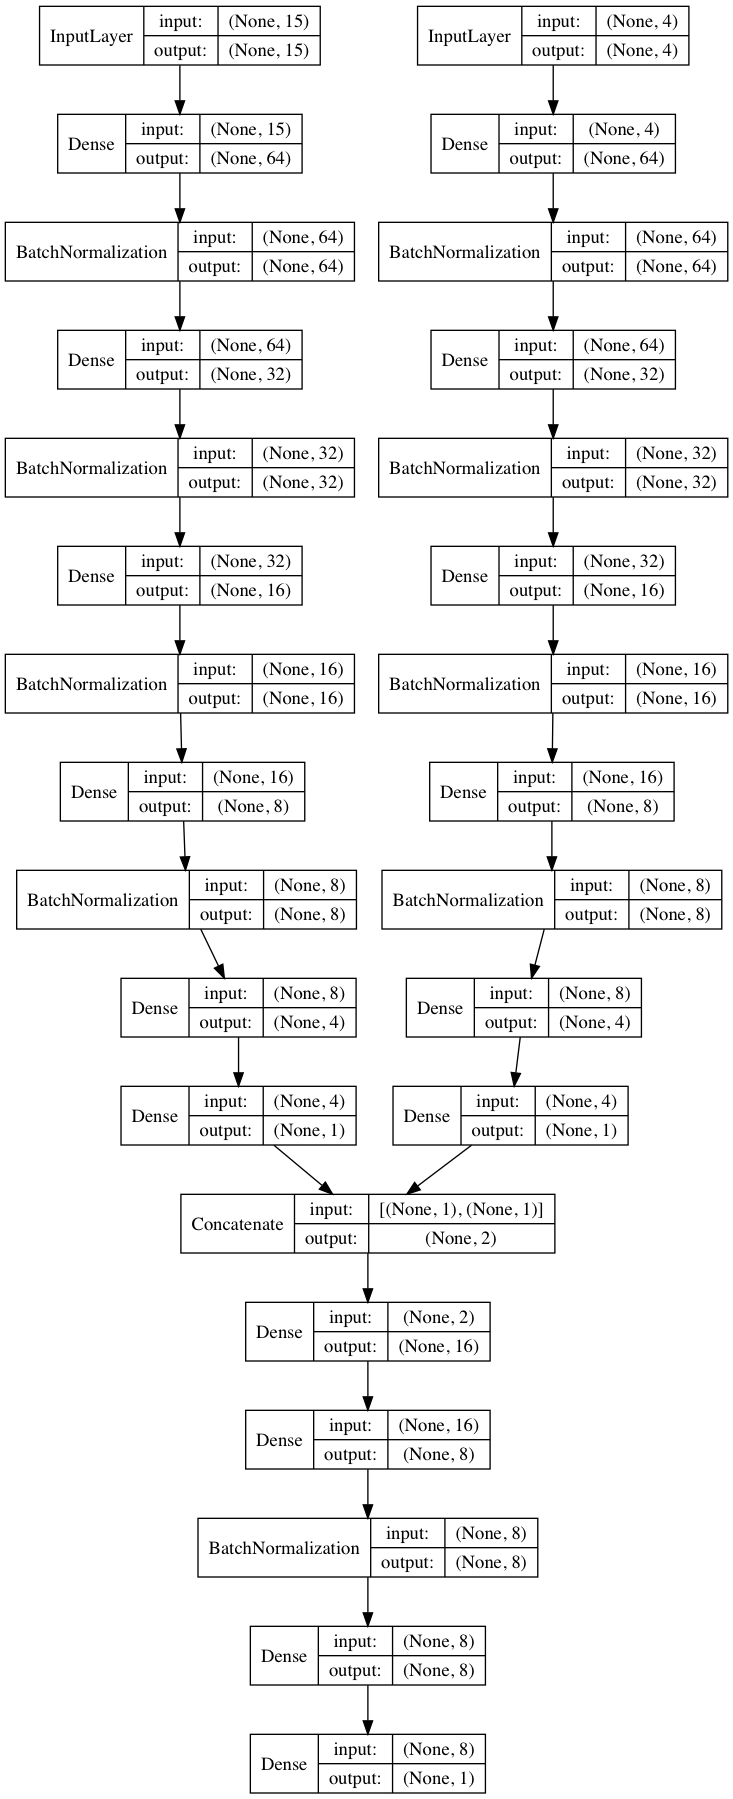

In [50]:
from IPython.display import Image
Image('model.png', width=200)

In [51]:
# alternatively you can render directly to Jupyter (result will not be as detailed)
# but you'll need to install `graphviz` for this diagram to be generated

# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot

# SVG(model_to_dot(model_new).create(prog='dot', format='svg'))

In [52]:
x_cat.shape

(713, 15)

In [53]:
x_num.shape

(713, 4)

In [54]:
history_final = model_new.fit([x_cat, x_num],
                                y_train,
                                epochs=150,
                                verbose=0,
                                batch_size=128,
                                validation_data=([x_cat_val, x_num_val], y_validation))

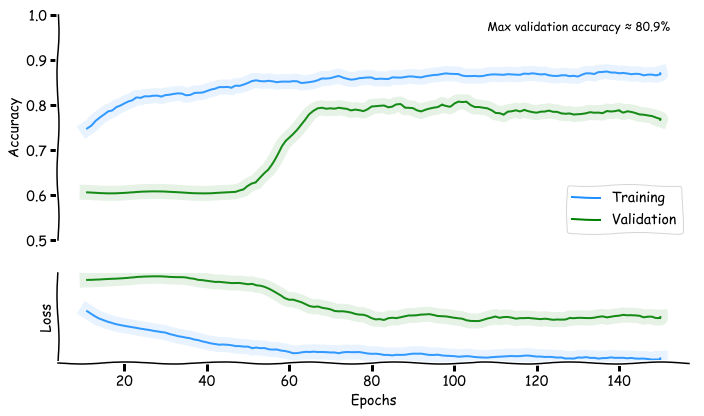

In [177]:
plot_history(history_final)

In [178]:
# model_new.save('model_new.h5')

# Alternative approach

## Built categorical model

In [179]:
result[one_hot_columns].shape

(891, 15)

In [180]:
# backend.clear_session()

model_cat = models.Sequential()
model_cat.add(layers.Dense(64, activation='relu', input_shape=(15,)))
model_cat.add(layers.Dense(32, activation='relu'))
model_cat.add(layers.BatchNormalization())
model_cat.add(layers.Dense(16, activation='relu'))
model_cat.add(layers.BatchNormalization())
model_cat.add(layers.Dense(8, activation='relu'))
model_cat.add(layers.BatchNormalization())
model_cat.add(layers.Dense(4, activation='relu'))
model_cat.add(layers.BatchNormalization())
# model_cat.add(layers.Dense(8, activation='relu'))
# model_cat.add(layers.Dense(4, activation='relu'))
# model_cat.add(layers.Dense(8, activation='relu'))
# model_cat.add(layers.Dense(32, activation='relu'))
model_cat.add(layers.Dense(1, activation='sigmoid'))

model_cat.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# model_cat.summary()

In [181]:
result = result.sample(frac=1)

In [182]:
x_data = result[one_hot_columns]
y_data = result['Survived']

In [183]:
result.head(5)

,Sex0,Sex1,Pclass0,Pclass1,Pclass2,Cabin0,Cabin1,Cabin2,Cabin4,Cabin5,Cabin6,Cabin7,Embarked0,Embarked1,Embarked2,SibSp,Parch,Age,Fare,Survived
187,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0.000,0.000000,0.5625,0.051822,1
101,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0.000,0.000000,0.0000,0.015412,0
353,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0.125,0.000000,0.3125,0.034743,0
771,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0.000,0.000000,0.6000,0.015330,0
201,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1.000,0.333333,0.0000,0.135753,0


## Train categorical

In [184]:
history_cat = model_cat.fit(x_data,
                            y_data,
                            epochs=300,
                            batch_size=len(x_data),
                            verbose=0,
                            validation_split=0.2)

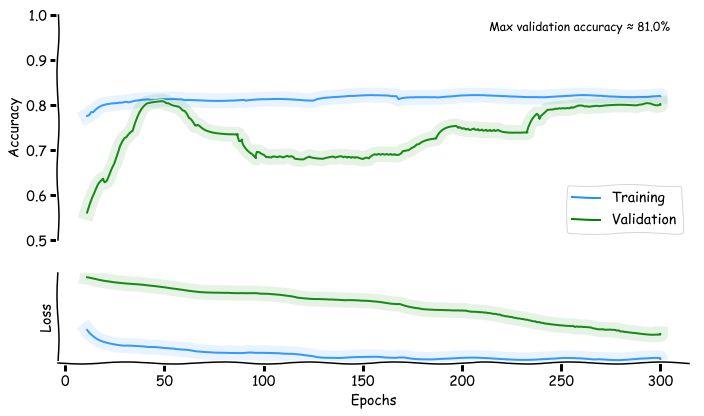

In [185]:
plot_history(history_cat)

## Build numerical

In [186]:
result.head(10)

,Sex0,Sex1,Pclass0,Pclass1,Pclass2,Cabin0,Cabin1,Cabin2,Cabin4,Cabin5,Cabin6,Cabin7,Embarked0,Embarked1,Embarked2,SibSp,Parch,Age,Fare,Survived
187,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0.000,0.000000,0.5625,0.051822,1
101,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0.000,0.000000,0.0000,0.015412,0
353,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0.125,0.000000,0.3125,0.034743,0
771,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0.000,0.000000,0.6000,0.015330,0
201,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1.000,0.333333,0.0000,0.135753,0
799,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0.125,0.166667,0.3750,0.047138,0
53,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0.125,0.000000,0.3625,0.050749,1
388,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0.000,0.000000,0.0000,0.015086,0
509,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0.000,0.000000,0.3250,0.110272,1
272,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0.000,0.166667,0.5125,0.038061,1


**Randomize the order of all the rows**

_this is important because the original data may not be (and in this case is not) random_

In [187]:
result = result.sample(frac=1)

Split validation & training data

In [188]:
x_data = result[numerical_data]
y_data = result['Survived']

In [189]:
# backend.clear_session()

model_num = models.Sequential()
model_num.add(layers.Dense(64, activation='relu', input_shape=(4,)))
# model_cat.add(layers.BatchNormalization())
model_num.add(layers.Dense(32, activation='relu'))
# model_cat.add(layers.BatchNormalization())
model_num.add(layers.Dense(16, activation='relu'))
# model_cat.add(layers.BatchNormalization())
model_num.add(layers.Dense(8, activation='relu'))
# model_cat.add(layers.BatchNormalization())
model_num.add(layers.Dense(4, activation='relu'))
# model_num.add(layers.Dense(8, activation='relu'))
# model_num.add(layers.Dense(4, activation='relu'))
# model_num.add(layers.Dense(32, activation='relu'))
model_num.add(layers.Dense(1, activation='sigmoid'))

model_num.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# model_num.summary()

## Train numerical

In [190]:
# note that we can use 
#   `validation_split=0.2` 
# instead of explicit validation
#   `validation_data=(x_validation, y_validation)`

history_num = model_num.fit(x_data,
                            y_data,
                            epochs=300,
                            batch_size=len(x_data),
                            verbose=0,
                            validation_split=0.2)

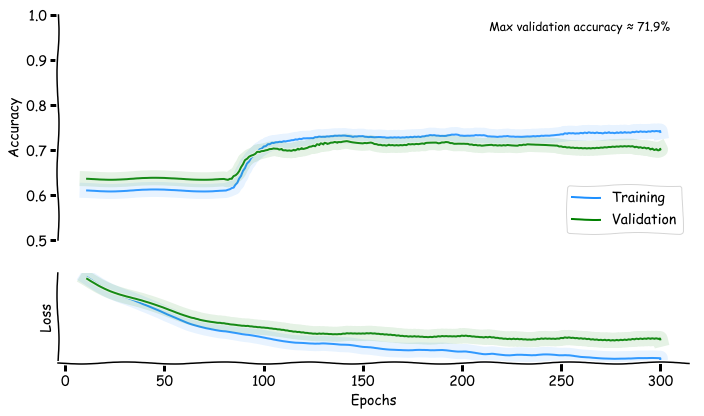

In [191]:
plot_history(history_num)

## Merge the two models

In [192]:
# model_cat.trainable = False
model_cat.trainable = True
# model_cat.summary()

In [193]:
# model_num.trainable = False
model_num.trainable = True
# model_num.summary()

In [194]:
# from keras.layers import concatenate

merge = concatenate([model_num.output, model_cat.output])

d1 = layers.Dense(16, activation='sigmoid')(merge)
d1n = layers.BatchNormalization()(d1)
d2 = layers.Dense(8,  activation='sigmoid')(d1n)
d2n = layers.BatchNormalization()(d2)
d3 = layers.Dense(4,  activation='sigmoid')(d2n)

output = layers.Dense(1, activation='sigmoid')(d3)

joint_model = models.Model(inputs=[model_num.input, model_cat.input], outputs=output)

In [195]:
joint_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [196]:
# joint_model.summary()

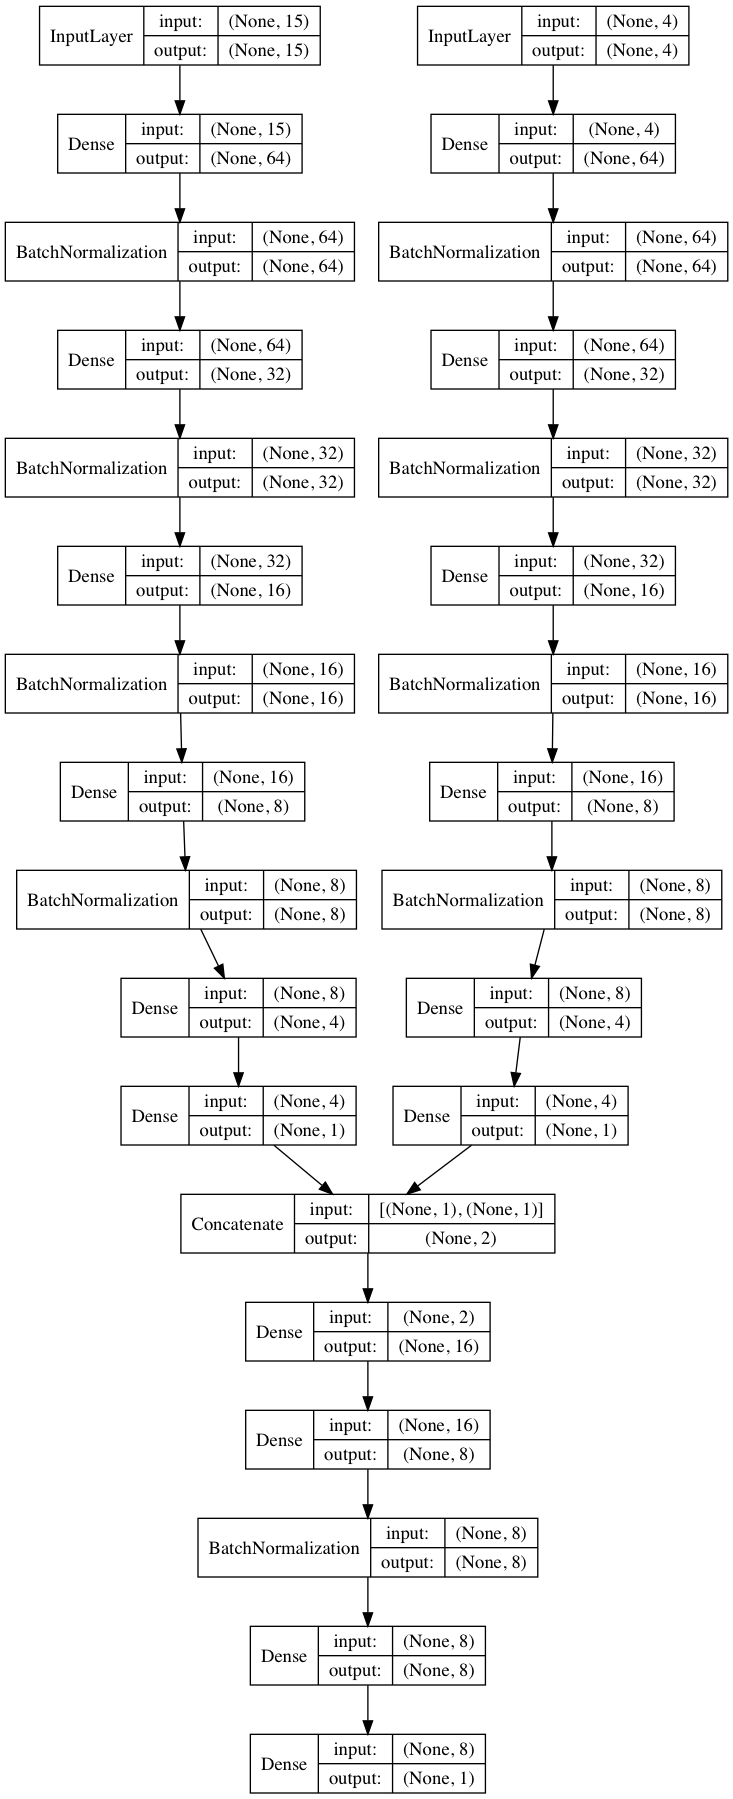

In [197]:
plot_model(model_new, show_shapes=True, to_file='model2.png', show_layer_names=False)
Image('model2.png', width=200)

In [198]:
history_final = joint_model.fit([x_num, x_cat],
                                y_train,
                                epochs=300,
                                verbose=0,
                                batch_size=128,
                                validation_split=0.2)

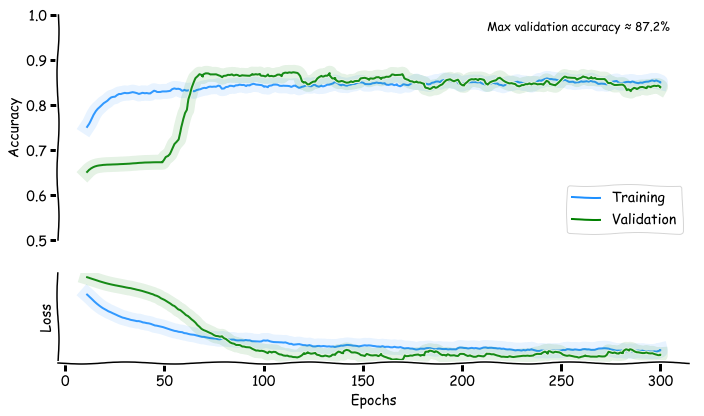

In [199]:
plot_history(history_final)

In [200]:
# joint_model.save('joint_model.h5')

## Archive: Keras one-hot method

In [201]:
from keras.utils import to_categorical

In [202]:
for col in categorical_data:
    print(col)
    lol = (to_categorical(df[col]))
    print(lol[:5])

Sex
[[ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]]
Pclass
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]]
Cabin
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.]]
Embarked
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]]


## Archive: Another way to plot

In [203]:
def plot_this(training, validation, label):
    
    epochs = range(1, len(training) + 1)
    
    plt.clf() # clear out old
    
    plt.xkcd() # make look like xkcd
    
#     plt.figure(figsize=(8, 3)) # make wider
    
    trim = 10 # remove first 10 data points

    plt.plot(epochs[trim:], training[trim:], 'b', label=('Training '+label))
    plt.plot(epochs[trim:], validation[trim:], 'g', label=('Validation '+label))
    plt.title('Model ' + label)
    plt.xlabel('Epochs')
    plt.ylabel(label)
    
    if label == 'Loss':
        plt.yticks([])
        
    if label == 'Accuracy':
        plt.ylim(ymin=0.5)
        plt.ylim(ymax=1)
        ymax = max(validation[trim:])
        best = 'Max validation accuracy ≈ ' + str(round(ymax, 3)*100) + '%'
        plt.text(0, 0.35, best, fontsize=12)
        
    plt.legend()

    return plt

In [204]:
def plot_history_old(history):

    label1 = 'Loss'
    train1 = smooth_curve(history.history['loss'])
    valid1 = smooth_curve(history.history['val_loss'])

    plot_this(train1, valid1, label1).show()
    
    label2 = 'Accuracy'
    train2 = smooth_curve(history.history['acc'])
    valid2 = smooth_curve(history.history['val_acc'])
    
    plot_this(train2, valid2, label2).show()

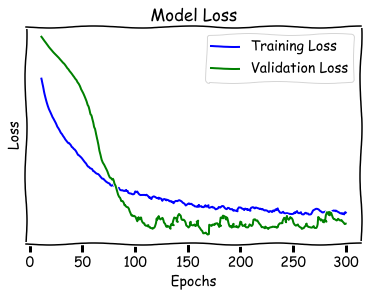

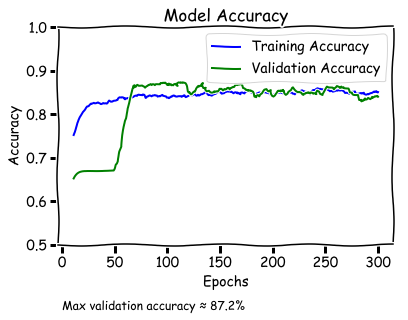

In [205]:
plot_history_old(history_final)